# Space time worms 

In [1]:
import os
from pathlib import Path
import json
import requests

#import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from geojson import Feature, Point, FeatureCollection, MultiPolygon, Polygon, load as geojson_load
from matplotlib import pyplot as plt

---

## 1 ) Helper functions

In [2]:
# earth radius in km
r = 6371 

# distance between two meridians (1 deg longitude) in km at given latitude
def dist_meridian_km(lat):
    u = 2*np.pi*r
    return np.cos(np.deg2rad(lat)) * u / 360

def dist_lon_deg(d_km, lat):
    return d_km / dist_meridian_km(lat)

def dist_lat_deg(d_km):
    return d_km * 360 / (2*np.pi*r)

def corridor_bbox(p, lat):
    return [p[0]-dist_lon_deg(dist, lat), 
         p[1]-dist_lat_deg(dist),
         p[0]+dist_lon_deg(dist, lat),
         p[1]+dist_lat_deg(dist)]

def bbox_to_polygon(bbox):
    return [[[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]],[bbox[0],bbox[1]]]]

def walk_groups(top):
    yield top.groups.values()
    for value in top.groups.values():
        yield from walktree(value)

In [3]:
#date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ')
date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M')

GFS_VAR_LIST = ['u-component_of_wind_maximum_wind', 'v-component_of_wind_maximum_wind', 'Temperature_surface']
WAVE_VAR_LIST = ['VHM0','VPED','VTPK']
PHYS_VAR_LIST =['so','uo','vo']

def build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi, 
                       wave_params=WAVE_VAR_LIST, phys_params=PHYS_VAR_LIST,
                       gfs_params=GFS_VAR_LIST, format='netcdf'):
    base_url = 'https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?'
    url = base_url + 'date_lo={}'.format(date_to_str(date_lo))
    url = url + '&date_hi={}'.format(date_to_str(date_hi))
    url = url + '&lat_lo={}'.format(lat_lo)
    url = url + '&lat_hi={}'.format(lat_hi)
    url = url + '&lon_lo={}'.format(lon_lo)
    url = url + '&lon_hi={}'.format(lon_hi)
    for param in wave_params:
        url = url + '&Wave={}'.format(param)
    for param in phys_params:
        url = url + '&Physical={}'.format(param)
    for param in gfs_params:
        url = url + '&GFS={}'.format(param)
    url = url + '&format={}'.format(format)

    return url

In [4]:
def save_with_groups(datasets, out, group_base='point'):
    """
    Save xarray datasets to netCDF file adding every dataset as separate group
    :param datasets: list of xarray datasets
    :out: str
        name of output file (absolute path)
    :group_base: str
        base name of the group (number is appended automatically)
    :returns: filename of created file
    """
    if Path(out).exists():
        try:
            os.remove(out)
            print('Removed file {}'.format(out))
        except OSError:
            pass
    
    for idx, dataset in enumerate(datasets):
        if idx == 0:
            dataset.to_netcdf(out, 'w', group='/{}_{}'.format(group_base, idx+1))
        else:
            dataset.to_netcdf(out, 'a', group='/{}_{}'.format(group_base, idx+1))
    
    return out

def save_with_local_grid(datasets, out):
    pass

---

## netCDF compression

In [5]:
# Define sample data with all elements masked out
#N = 1000
#data = np.ma.masked_all((N, N))

In [6]:
# Write data to netCDF file using different data formats
#for fmt in ('NETCDF3_CLASSIC', 'NETCDF4'):
#    fname = 'test.nc'
#    ds = netCDF4.Dataset(fname, format=fmt, mode='w')
#    xdim = ds.createDimension(dimname='x', size=N)
#    ydim = ds.createDimension(dimname='y', size=N)
#    var = ds.createVariable(
#        varname='data',
#        dimensions=(ydim.name, xdim.name),
#        fill_value=-999,
#        datatype='f4',
#        complevel=9,  # set gzip compression level
#        zlib=True  # enable compression
#    )
#    var[:] = data
#    ds.close()
#
#    # Determine file size
#    print(fmt, os.stat(fname).st_size)

---

## 2) Define route 

### 2.1) From scrubber data 

<ol>
  <li>Read example scrubber trajectory data</li>
  <li>Define time series for 2 days with a 3-hour interval</li>
  <li>Extract coordinates for time series from step 2</li>
  <li>Create geojson with time series and coordinates</li>
</ol>


In [7]:
#df = pd.read_csv('/home/martin/Projekte/MariData/data/Buettner/CB_scrubber_parsed.csv')

In [8]:
#times = pd.date_range("2021-04-02 00:00:00", periods=16, freq="3H")
#times

In [9]:
#time_filter = [False] * len(df)
#for time in times:
#    time_filter = time_filter | (df['Date/Time (UTC)'] >= str(time+pd.Timedelta(-2,'m'))) & (df['Date/Time (UTC)'] <= str(time+pd.Timedelta(2,'m')))

#df_filtered = df[time_filter]
#print(len(df_filtered))
#df_filtered

In [10]:
#points = list(zip(round(df_filtered['Longitude'], 1),round(df_filtered['Latitude'], 1)))
#points

In [11]:
#point_features = []

#for idx, point in enumerate(points):
#    point_features.append(Feature(geometry=Point(point), properties={"time": str(times[idx])}))

#route_geojson = FeatureCollection(point_features)
#print(json.dumps(route_geojson, indent=2))

### 2.2) From geojson 

In [12]:
with open('space_time_worm.geojson') as f:
    route_geojson = geojson_load(f)
times = pd.date_range(route_geojson['features'][0]['properties']['time'],route_geojson['features'][-1]['properties']['time'], freq="3H")
points = [tuple(p['geometry']['coordinates']) for p in route_geojson['features'] if p['geometry']['type']=='Point']

---

## 3) Define bboxes

In [13]:
# Distance/width of the corridor (total width/total height of bbox = 2*distance)
dist = 30
# Use maximum latitude as it will produce the largest bbox
lat_max = np.max([p[1] for p in points])
print('Maximum latitude:', lat_max)

Maximum latitude: 51.3


In [14]:
bboxes = []
polygon_features = []
for idx, p in enumerate(points):
    bbox = corridor_bbox(p, lat_max)
    bboxes.append(bbox)
    polygon = bbox_to_polygon(bbox)
    polygon_features.append(Feature(geometry=Polygon(polygon), properties={"time": str(times[idx])}))
    print("[{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}]".format(*bbox))

bboxes_geojson = FeatureCollection(polygon_features)

[-2.432, 45.530, -1.568, 46.070]
[-3.232, 45.930, -2.368, 46.470]
[-4.032, 46.330, -3.168, 46.870]
[-4.732, 46.830, -3.868, 47.370]
[-5.532, 47.330, -4.668, 47.870]
[-6.132, 47.830, -5.268, 48.370]
[-6.132, 48.430, -5.268, 48.970]
[-5.232, 48.830, -4.368, 49.370]
[-4.432, 49.130, -3.568, 49.670]
[-3.632, 49.430, -2.768, 49.970]
[-2.832, 49.630, -1.968, 50.170]
[-2.032, 49.730, -1.168, 50.270]
[-0.832, 49.930, 0.032, 50.470]
[0.268, 50.130, 1.132, 50.670]
[0.968, 50.630, 1.832, 51.170]
[1.668, 51.030, 2.532, 51.570]


In [15]:
print(json.dumps(bboxes_geojson, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -2.431507,
              45.530204
            ],
            [
              -1.568493,
              45.530204
            ],
            [
              -1.568493,
              46.069796
            ],
            [
              -2.431507,
              46.069796
            ],
            [
              -2.431507,
              45.530204
            ]
          ]
        ]
      },
      "properties": {
        "time": "2021-04-02 00:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -3.231507,
              45.930204
            ],
            [
              -2.368493,
              45.930204
            ],
            [
              -2.368493,
              46.469796
       

In [16]:
#print(json.dumps(FeatureCollection(point_features+polygon_features), indent=2))

---

## 4) Download data along route

Download data using the Environmental Data API: https://harvester.maridata.dev.52north.org/EnvDataAPI/

Documentation: https://github.com/52North/MariDataHarvest/tree/main/EnvDataServer

In [111]:
data_links = []
headers = {'Accept': 'application/json'}

for j in range(0, len(bboxes)):
    if len(bboxes) != len(times):
        break
    lon_lo = bboxes[j][0]
    lon_hi = bboxes[j][2]
    lat_lo = bboxes[j][1]
    lat_hi = bboxes[j][3]
    date_lo = times[j]
    date_hi = times[j]
    
    url = build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi)
    print('Requesting: {}'.format(url))
    resp = requests.get(url, headers=headers)
    if resp.status_code == 200:
        resp_data = resp.json()
        data_links.append(resp_data['link'])
        print('Response: {}'.format(resp_data))
    else:
        print('Response: {}'.format(resp.status_code))

Requesting: https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?date_lo=2021-04-02T12:00&date_hi=2021-04-02T12:00&lat_lo=47.33020351822438&lat_hi=47.86979648177562&lon_lo=-5.531506838251867&lon_hi=-4.668493161748132&Wave=VHM0&Wave=VPED&Wave=VTPK&Physical=so&Physical=uo&Physical=vo&GFS=u-component_of_wind_maximum_wind&GFS=v-component_of_wind_maximum_wind&GFS=Temperature_surface&format=netcdf
Response: {'limit': '2021-12-17T18:18:37+00:00', 'link': 'https://harvester.maridata.dev.52north.org/EnvDataAPI/fd3134fa-5f54-11ec-88c5-0242ac120003.nc'}


In [120]:
data_links

['https://harvester.maridata.dev.52north.org/EnvDataAPI/fd3134fa-5f54-11ec-88c5-0242ac120003.nc']

---

## 5) Visualize downloaded data

ToDo: preprocessing (reduce time dimension and sort datasets, ...)

In [121]:
base_source = '/home/martin/Projekte/MariData/software/space_time_worms/source_data/17_12_2021'
file_names = []

for file in os.listdir(base_source):
    file_names.append(os.path.join(base_source, file))

In [122]:
datasets = []
for file_name in file_names:
    datasets.append(xr.load_dataset(file_name))

In [123]:
# For debug
#ds_times = []
#for dataset in datasets:
#    ds_times.append(dataset.time.values)
#    print(dataset.time.values)
#ds_times = [item for sublist in ds_times for item in sublist]

In [124]:
# For debug
#ds_times.sort()
#ds_times

In [125]:
# For debug
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 09:00:00')
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 12:00:00')

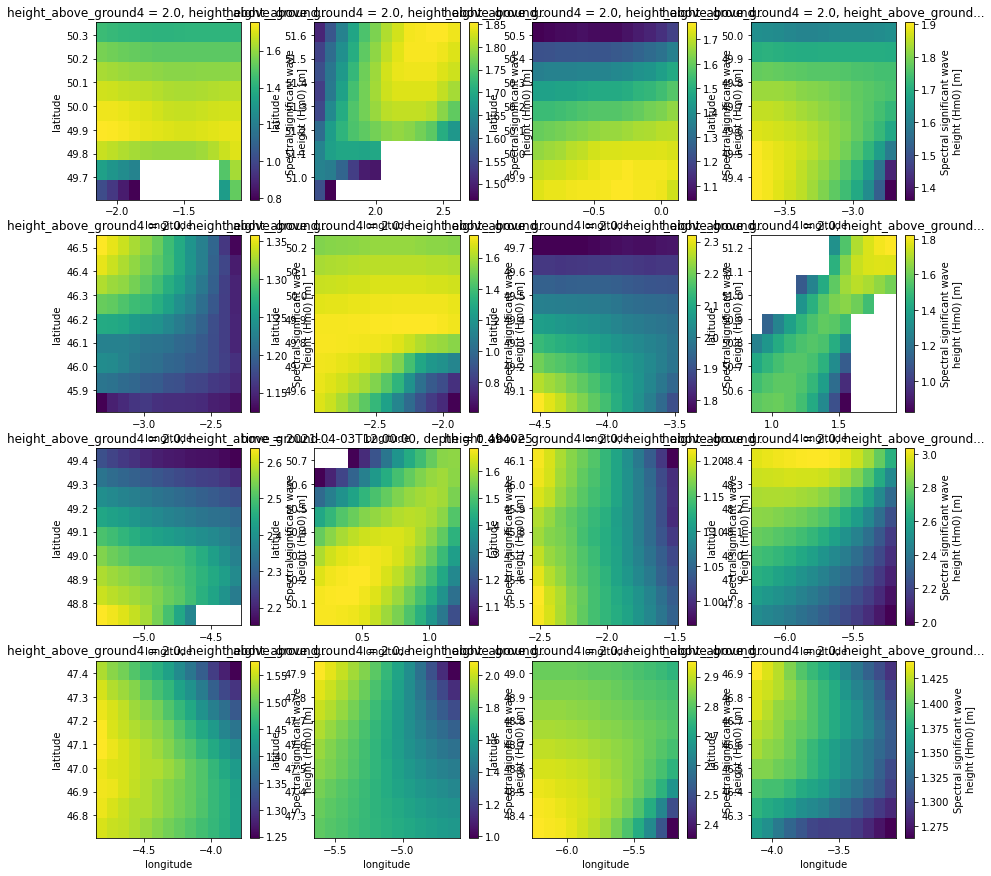

In [126]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 6) Space time worm with netCDF groups

xarray does not support a data structure with multiple groups. A Dataset corrsponds to a single group in a netCDF file.
http://xarray.pydata.org/en/stable/user-guide/io.html#groups

In [23]:
out = '/home/martin/Projekte/MariData/software/space_time_worms/cmems_cube_groups.nc'
save_with_groups(datasets, out)

Removed file /home/martin/Projekte/MariData/software/space_time_worms/cmems_cube_groups.nc


'/home/martin/Projekte/MariData/software/space_time_worms/cmems_cube_groups.nc'

---

## 7) Space time worm with relative coordinates (single grid)

Challenges:
* How to make sure all relative grids are identical?

### 7.1) Transform grid

In [24]:
def transform_coordinates(datasets):
    for idx, dataset in enumerate(datasets):
        datasets[idx] = dataset.assign_coords(longitude=lambda dataset: dataset.longitude - p1[0])
        datasets[idx] = dataset.assign_coords(latitude=lambda dataset: dataset.latitude - p1[1])
        print(dataset)
    return datasets

In [25]:
ds1_rel = ds1.copy()
ds2_rel = ds2.copy()
ds2_rel

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 7, longitude: 13)
Coordinates:
  * latitude   (latitude) float64 52.75 52.83 52.92 53.0 53.08 53.17 53.25
  * time       (time) datetime64[ns] 2021-12-10T18:00:00
  * longitude  (longitude) float64 2.5 2.583 2.667 2.75 ... 3.25 3.333 3.417 3.5
Data variables: (12/17)
    VHM0_WW    (time, latitude, longitude) float32 2.65 2.67 2.68 ... 1.42 0.67
    VMDR_SW2   (time, latitude, longitude) float32 1.93 239.8 ... 218.0 190.1
    VMDR       (time, latitude, longitude) float32 324.8 324.3 ... 312.2 308.3
    VMDR_SW1   (time, latitude, longitude) float32 23.57 23.58 ... 290.9 305.0
    VTM10      (time, latitude, longitude) float32 6.34 6.35 6.36 ... 6.11 6.17
    VPED       (time, latitude, longitude) float32 337.5 337.5 ... 311.5 307.8
    ...         ...
    VSDX       (time, latitude, longitude) float32 0.12 0.12 0.12 ... 0.08 0.07
    VTM01_SW1  (time, latitude, longitude) float32 6.9 6.97 7.01 ... 5.88 5.52
    VSDY       (time, latitude, longitude) float32 -0.16 -0.16 ... -0.11 -0.07
    VHM0       (time, latitude, longitude) float32 2.66 2.68 2.69 ... 2.04 1.87
    VTM01_WW   (time, latitude, longitude) float32 5.81 5.83 5.84 ... 4.37 3.2
    VHM0_SW2   (time, latitude, longitude) float32 0.07 0.07 0.07 ... 0.21 0.27
Attributes: (12/31)
    Conventions:                               CF-1.6
    time_coverage_start:                       20211218-03:00:00
    time_coverage_end:                         20211219-00:00:00
    date_created:                              20211209-07:35:00
    product_type:                              forecast
    product:                                   GLOBAL_ANALYSIS_FORECAST_WAV_0...
    ...                                        ...
    FROM_ORIGINAL_FILE__geospatial_lat_step:   0.08333588
    FROM_ORIGINAL_FILE__geospatial_lat_units:  degree
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

In [28]:
#print(type(ds1_rel.latitude)) # <class 'xarray.core.dataarray.DataArray'>
#print(type(ds1_rel.latitude.values)) # <class 'numpy.ndarray'>
ds1_rel = ds1_rel.assign_coords(longitude=lambda ds1_rel: ds1_rel.longitude - p1[0])
ds1_rel = ds1_rel.assign_coords(latitude=lambda ds1_rel: ds1_rel.latitude - p1[1])

ds2_rel = ds2_rel.assign_coords(longitude=lambda ds2_rel: ds2_rel.longitude - p2[0])
ds2_rel = ds2_rel.assign_coords(latitude=lambda ds2_rel: ds2_rel.latitude - p2[1])
ds2_rel

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 7, longitude: 13)
Coordinates:
  * latitude   (latitude) float64 -0.25 -0.1667 -0.08333 0.0 0.08333 0.1667 0.25
  * time       (time) datetime64[ns] 2021-12-10T18:00:00
  * longitude  (longitude) float64 -0.5 -0.4167 -0.3333 ... 0.3333 0.4167 0.5
Data variables: (12/17)
    VHM0_WW    (time, latitude, longitude) float32 2.65 2.67 2.68 ... 1.42 0.67
    VMDR_SW2   (time, latitude, longitude) float32 1.93 239.8 ... 218.0 190.1
    VMDR       (time, latitude, longitude) float32 324.8 324.3 ... 312.2 308.3
    VMDR_SW1   (time, latitude, longitude) float32 23.57 23.58 ... 290.9 305.0
    VTM10      (time, latitude, longitude) float32 6.34 6.35 6.36 ... 6.11 6.17
    VPED       (time, latitude, longitude) float32 337.5 337.5 ... 311.5 307.8
    ...         ...
    VSDX       (time, latitude, longitude) float32 0.12 0.12 0.12 ... 0.08 0.07
    VTM01_SW1  (time, latitude, longitude) float32 6.9 6.97 7.01 ... 5.88 5.52
    VSDY       (time, latitude, longitude) float32 -0.16 -0.16 ... -0.11 -0.07
    VHM0       (time, latitude, longitude) float32 2.66 2.68 2.69 ... 2.04 1.87
    VTM01_WW   (time, latitude, longitude) float32 5.81 5.83 5.84 ... 4.37 3.2
    VHM0_SW2   (time, latitude, longitude) float32 0.07 0.07 0.07 ... 0.21 0.27
Attributes: (12/31)
    Conventions:                               CF-1.6
    time_coverage_start:                       20211218-03:00:00
    time_coverage_end:                         20211219-00:00:00
    date_created:                              20211209-07:35:00
    product_type:                              forecast
    product:                                   GLOBAL_ANALYSIS_FORECAST_WAV_0...
    ...                                        ...
    FROM_ORIGINAL_FILE__geospatial_lat_step:   0.08333588
    FROM_ORIGINAL_FILE__geospatial_lat_units:  degree
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

### 7.2) Combine datasets

In [29]:
combined = xr.concat([ds1_rel, ds2_rel], dim='time')
combined

<xarray.Dataset>
Dimensions:    (time: 2, latitude: 7, longitude: 13)
Coordinates:
  * latitude   (latitude) float64 -0.25 -0.1667 -0.08333 0.0 0.08333 0.1667 0.25
  * time       (time) datetime64[ns] 2021-12-09T18:00:00 2021-12-10T18:00:00
  * longitude  (longitude) float64 -0.5 -0.4167 -0.3333 ... 0.3333 0.4167 0.5
Data variables: (12/17)
    VHM0_WW    (time, latitude, longitude) float32 1.76 1.72 1.67 ... 1.42 0.67
    VMDR_SW2   (time, latitude, longitude) float32 307.3 307.1 ... 218.0 190.1
    VMDR       (time, latitude, longitude) float32 170.0 170.6 ... 312.2 308.3
    VMDR_SW1   (time, latitude, longitude) float32 214.9 215.1 ... 290.9 305.0
    VTM10      (time, latitude, longitude) float32 5.9 5.87 5.84 ... 6.11 6.17
    VPED       (time, latitude, longitude) float32 192.7 199.5 ... 311.5 307.8
    ...         ...
    VSDX       (time, latitude, longitude) float32 -0.07 -0.07 ... 0.08 0.07
    VTM01_SW1  (time, latitude, longitude) float32 6.05 6.03 6.03 ... 5.88 5.52
    VSDY       (time, latitude, longitude) float32 0.13 0.13 ... -0.11 -0.07
    VHM0       (time, latitude, longitude) float32 2.09 2.05 2.01 ... 2.04 1.87
    VTM01_WW   (time, latitude, longitude) float32 4.83 4.77 4.7 ... 4.37 3.2
    VHM0_SW2   (time, latitude, longitude) float32 0.26 0.26 0.3 ... 0.21 0.27
Attributes: (12/31)
    Conventions:                               CF-1.6
    time_coverage_start:                       20211218-03:00:00
    time_coverage_end:                         20211219-00:00:00
    date_created:                              20211209-07:35:00
    product_type:                              forecast
    product:                                   GLOBAL_ANALYSIS_FORECAST_WAV_0...
    ...                                        ...
    FROM_ORIGINAL_FILE__geospatial_lat_step:   0.08333588
    FROM_ORIGINAL_FILE__geospatial_lat_units:  degree
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

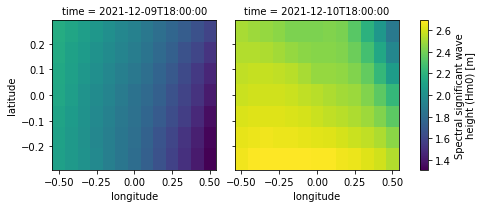

In [30]:
combined.VHM0.plot(x="longitude", y="latitude", col="time");

In [31]:
# ToDo: add grid transform to attributes

In [32]:
out = '/home/martin/Projekte/MariData/software/space_time_worms/cmems_cube_relative_coordinates.nc'
combined.to_netcdf(out)

---

## 8) Memory comparison

In [28]:
#print(os.stat(base + 'global-analysis-forecast-wav-001-027_1639067263072.nc').st_size / 1000, 'kB')
#print(os.stat(base + 'global-analysis-forecast-wav-001-027_1639067209562.nc').st_size / 1000, 'kB')